## Two objects dataset
Simple version of two objects dataset. Added "near" relation. No "on" relation. 

In [309]:
import numpy as np

import sampling
from sampling import create_shape
from evaluation import evaluate_sample
from environment import grab_frame, reset_env
from predicates import AtomPredicate, AtomRelation, AtomColor, AtomObject

frame_size = (64, 64)
dataset_path = 'data/two_objects_dataset_64'

def sample_func():
    bounds = (4.0, 4.0, 0.0)
    obj_1 = sampling.ObjectOnTable.sample(origin=(0, 0, 1.0), max_bounds=bounds, max_rotation=2 * np.pi)
    obj_2 = sampling.ObjectOnTable.sample_no_intersection(
        origin=(0, 0, 1.0), max_bounds=bounds, max_rotation=2 * np.pi, existing_objects=[obj_1], min_distance=2.0
    )    
    
    predicates = (
        sampling.get_on_table_relation(obj_1, bounds, add_positional=False) + 
        sampling.get_on_table_relation(obj_2, bounds, add_positional=False)
        #sampling.get_near_relation([obj_1, obj_2])
    )

    if obj_1.obj_type != obj_2.obj_type and obj_1.color != obj_2.color:
        predicates.extend([
            (AtomPredicate(AtomRelation.ON, obj_1.obj_type, obj_2.color, AtomObject.TABLE, AtomColor.NO_COLOR), 0.0),
            (AtomPredicate(AtomRelation.ON, obj_2.obj_type, obj_1.color, AtomObject.TABLE, AtomColor.NO_COLOR), 0.0),
        ])    
        predicates.extend(sampling.get_false_predicates(predicates, 2))
    else:
        predicates.extend(sampling.get_false_predicates(predicates, 4))

    reset_env()
    create_shape(obj_1)
    create_shape(obj_2)
    frame = grab_frame(cam_pos=(0, -10, 12), cam_target=(0, -1, 0), light_dir=(-6, 1, 10), frame_size=frame_size)
    return frame, predicates
    

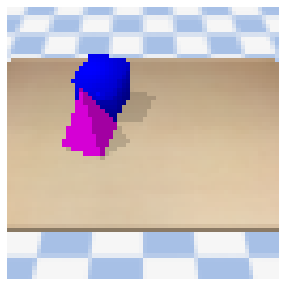

(blue cube on table) 1.0
(purple pyramid on table) 1.0
(purple cube on table) 0.0
(blue pyramid on table) 0.0
(purple sphere on table) 0.0
(green pyramid on table) 0.0


In [310]:
evaluate_sample(sample_func)

In [312]:
# Run only once!
from batching import create_dataset

create_dataset(dataset_path, num_batches=128, batch_size=128, sample_func=sample_func)
create_dataset(dataset_path + '_test', num_batches=8, batch_size=128, sample_func=sample_func)

Generating 128 * 128 = 16384 samples


100%|██████████| 128/128 [07:15<00:00,  3.41s/it]


Generating 8 * 128 = 1024 samples


100%|██████████| 8/8 [00:28<00:00,  3.57s/it]


In [337]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

frame_inputs = layers.Input(shape=(*frame_size, 3))
x = layers.Rescaling(1.0 / 255.0)(frame_inputs)

for size in (8, 8, 16):
    x = layers.Conv2D(size, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D(2, padding="same")(x)        

x = layers.Flatten()(x)
conv_branch_outputs = layers.Dense(64, activation='relu')(x)

predicate_inputs = layers.Input(shape=(33,))
predicate_branch_outputs = layers.Dense(64, activation='relu')(predicate_inputs)

x = layers.concatenate([conv_branch_outputs, predicate_branch_outputs], axis=-1)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model([frame_inputs, predicate_inputs], outputs)
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 64, 64, 3)    0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 64, 8)    224         rescaling_8[0][0]                
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [279]:
from batching import load_as_tf_dataset
training_set = load_as_tf_dataset(dataset_path).shuffle(128).batch(32)
testing_set = load_as_tf_dataset(dataset_path + "_test").batch(32)

In [314]:
from batching import load_datasets

training_set = load_datasets(["data/one_object_dataset_64", dataset_path]).shuffle(128).batch(32)
testing_set = load_datasets(["data/one_object_dataset_64_test", dataset_path + "_test"]).batch(32)

Datasets contain 256 files in total.
Datasets contain 16 files in total.


In [338]:
model.load_weights("models/one_object_64input_8_8_16conv_64_128dense.h5")

In [369]:
%%time
model.optimizer.learning_rate = 1e-4
progress = model.fit(training_set, validation_data=testing_set, epochs=5)

Epoch 1/5
7680/7680 [==============================] - 83s 11ms/step - loss: 0.0363 - accuracy: 0.9588 - val_loss: 0.0555 - val_accuracy: 0.9536
Epoch 2/5
7680/7680 [==============================] - 83s 11ms/step - loss: 0.0353 - accuracy: 0.9592 - val_loss: 0.0549 - val_accuracy: 0.9541
Epoch 3/5
7680/7680 [==============================] - 83s 11ms/step - loss: 0.0347 - accuracy: 0.9594 - val_loss: 0.0542 - val_accuracy: 0.9535
Epoch 4/5
7680/7680 [==============================] - 82s 11ms/step - loss: 0.0339 - accuracy: 0.9596 - val_loss: 0.0528 - val_accuracy: 0.9533
Epoch 5/5
7680/7680 [==============================] - 82s 11ms/step - loss: 0.0334 - accuracy: 0.9599 - val_loss: 0.0538 - val_accuracy: 0.9542
CPU times: user 6min 39s, sys: 40.4 s, total: 7min 20s
Wall time: 6min 53s


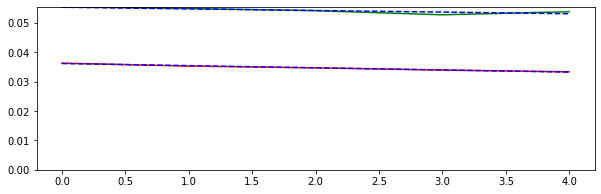

In [370]:
from utils import draw_progress
draw_progress(progress, fit_line=True)

In [373]:
probes = sampling.get_on_table_probes(add_positional=True)
#probes = sampling.get_near_probes()

In [197]:
probes.shape

(324, 33)

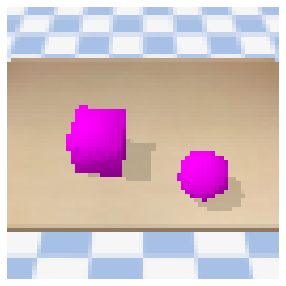

(purple sphere on table) 1.0
(purple cube on table) 1.0
(yellow pyramid on table) 0.0
(green cube on table) 0.0
(purple pyramid on table) 0.0
(blue cube on table) 0.0
---
(purple cube on table) 0.99999535
(purple cube on_near_side_of table) 0.9992373
(purple sphere on table) 0.99876463
(purple cube on_left_side_of table) 0.9765089


In [380]:
evaluate_sample(sample_func, model, probes)